In [1]:
import tensorflow_datasets as tfds

In [2]:

# Load the MNIST dataset
dataset, info = tfds.load('mnist', with_info=True, as_supervised=True, shuffle_files=True)

# Get the train and test datasets
train_dataset, test_dataset = dataset['train'], dataset['test']

# Print dataset info
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='C:\\Users\\sudip\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [3]:
import tensorflow as tf

In [4]:
from functools import partial

In [5]:

MyConv2D=partial(tf.keras.layers.Conv2D,kernel_size=(3,3),padding='same',dilation_rate=(1,1),strides=(1,1),kernel_initializer='he_normal',use_bias=False,activation=None)

In [10]:

class ResU2(tf.keras.layers.Layer):
    def __init__(self,filters,strides,activation='relu',**kwargs):
        super().__init__(**kwargs)
        self.activation=tf.keras.activations.get(activation)
        self.main_layers=[MyConv2D(filters,strides=strides),tf.keras.layers.BatchNormalization(),self.activation,MyConv2D(filters),tf.keras.layers.BatchNormalization()]
        self.skip_layers=[MyConv2D(filters,kernel_size=(1,1),strides=strides),tf.keras.layers.BatchNormalization()]
    def call(self,inputs):
        Z=inputs
        for layer in self.main_layers:
            Z=layer(Z)
        skip_Z=inputs
        for layer in self.skip_layers:
            skip_Z=layer(skip_Z)
        Z=Z+skip_Z
        Z=self.activation(Z)
        return Z

In [7]:
model=tf.keras.Sequential()
model.add(MyConv2D(filters=64,kernel_size=(7,7),strides=2,input_shape=[28,28,1]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2),padding='same'))

#Residual Blocks

prev_filters=64
for filters in [64]*3+[128]*4+[256]*6+[512]*3:
    strides=1 if filters==prev_filters else 2
    model.add(ResU2(filters,strides))
    prev_filters=filters

#Last Layers
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10,activation='softmax'))

C:\Users\sudip\PycharmProjects\pythonProject\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2 (ResU2)                       │ (None, 7, 7, 64)            │          78,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_1 (ResU2)                     │ (None, 7, 7, 64)            │          78,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_2 (ResU2)                     │ (None, 7, 7, 64)            │          78,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_3 (ResU2)                     │ (None, 4, 4, 128)           │         230,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_4 (ResU2)                     │ (None, 4, 4, 128)           │         312,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_5 (ResU2)                     │ (None, 4, 4, 128)           │         312,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_6 (ResU2)                     │ (None, 4, 4, 128)           │         312,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_7 (ResU2)                     │ (None, 2, 2, 256)           │         920,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_8 (ResU2)                     │ (None, 2, 2, 256)           │       1,248,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_9 (ResU2)                     │ (None, 2, 2, 256)           │       1,248,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_10 (ResU2)                    │ (None, 2, 2, 256)           │       1,248,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_11 (ResU2)                    │ (None, 2, 2, 256)           │       1,248,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_12 (ResU2)                    │ (None, 2, 2, 256)           │       1,248,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_13 (ResU2)                    │ (None, 1, 1, 512)           │       3,676,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_14 (ResU2)                    │ (None, 1, 1, 512)           │       4,986,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_u2_15 (ResU2)                    │ (None, 1, 1, 512)           │       4,986,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │              

 Total params: 22,225,482 (84.78 MB)

 Trainable params: 22,202,698 (84.70 MB)

 Non-trainable params: 22,784 (89.00 KB)

In [9]:
import numpy as np
import matplotlib.pyplot as pl
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset:
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

# Convert train and test datasets to NumPy arrays
x_train, y_train = dataset_to_numpy(train_dataset)
x_test, y_test = dataset_to_numpy(test_dataset)

In [10]:
x_train.shape

(60000, 28, 28, 1)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:

x_train_split,x_val,y_train_split,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=42,shuffle=True,stratify=y_train)

In [13]:
x_train.shape

(60000, 28, 28, 1)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Nadam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [15]:
from pathlib import Path
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model.keras",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
#run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
#tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb]#, tensorboard_cb]

In [16]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=30,callbacks=callbacks)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1372s 708ms/step - accuracy: 0.8477 - loss: 0.5182 - val_accuracy: 0.9768 - val_loss: 0.0902
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1331s 710ms/step - accuracy: 0.9700 - loss: 0.1150 - val_accuracy: 0.9822 - val_loss: 0.0738
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1289s 688ms/step - accuracy: 0.9762 - loss: 0.0984 - val_accuracy: 0.9841 - val_loss: 0.0661
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1115s 595ms/step - accuracy: 0.9808 - loss: 0.0781 - val_accuracy: 0.9788 - val_loss: 0.1051
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1143s 610ms/step - accuracy: 0.9822 - loss: 0.0723 - val_accuracy: 0.9918 - val_loss: 0.0387
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1199s 640ms/step - accuracy: 0.9849 - loss: 0.0600 - val_accuracy: 0.9815 - val_loss: 0.0720
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1122s 598ms/step - accuracy: 0.9884 - loss: 0.0444 - val_accuracy: 0.9843 - val_loss: 0.0671
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1138s 607ms/s

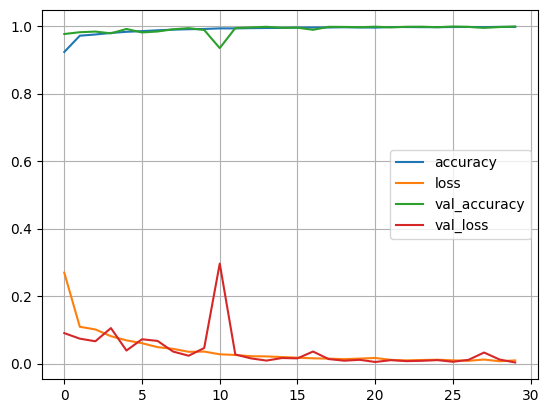

In [17]:
import pandas as pd
pd.DataFrame(history.history).plot(grid=True)
pl.show()

In [18]:
model.evaluate(x_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 92ms/step - accuracy: 0.9932 - loss: 0.0260


[0.02551640197634697, 0.9940000176429749]

In [19]:
model.save('my_mnist_model_resnet.keras')

# Final Accuracy on entire dataset= 99.7589%(without any preprocessing)(Error rate=0.2411%)